In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from functools import partial
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.linalg import sqrtm

from tqdm import tqdm
from PDE_solver_backend import Aggregate,PDESolver

In [5]:
def make_points_inside(Nd,range_model=np.array([[-1,1],[-1,1]])):
    assert range_model.shape==(2,2) and np.all(range_model[:,1:]-range_model[:,:1]>=0)
    clipped=np.clip(range_model,-1,1)

    return (clipped[:,1:]-clipped[:,:1]).T*np.random.rand(Nd,2)+clipped[:,:1].T

def make_points_boundary(Nb):
    X=np.stack([2*np.random.rand(Nb)-1,2*np.random.randint(0,2,Nb)-1]).T
    list(map(np.random.shuffle, X))
    np.random.shuffle(X)
    return X

In [8]:
from sympy import cos,sin,pi,symbols,diff,lambdify

x,y = symbols('x,y')
#u_symbolic=(x**2-1)/(1-0.95*sin(4*pi*y))*sin(pi*y)
u_symbolic=cos(4*pi*x)*cos(pi/2*y)
laplacian=lambda f:diff(f,x,x)+diff(f,y,y)
f_symbolic=u_symbolic**3-laplacian(u_symbolic)
f_symbolic

cos(4*pi*x)**3*cos(pi*y/2)**3 + 65*pi**2*cos(4*pi*x)*cos(pi*y/2)/4

In [9]:
#real_u=lambda x:np.cos(np.pi*x[0]/2)*np.cos(np.pi*x[1]/2)
real_u_tuple=lambdify((x,y),u_symbolic)
real_u=lambda xy:real_u_tuple(xy[0],xy[1])
#f=lambda x:real_u(x)*np.pi**2/2+(real_u(x))**3
f_tuple=lambdify((x,y),f_symbolic)
f=lambda xy:f_tuple(xy[0],xy[1])
#g=lambda x:0
tau=lambda x:np.power(x,3)
dtau=lambda x:3*x**2

In [10]:
def plot_vectorized_function(f,mesh_size=0.05):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.arange(-1.0, 1.0, mesh_size)
    X, Y = np.meshgrid(x, y)
    Z=f(np.stack([X.flatten(),Y.flatten()],axis=-1)).reshape(X.shape)

    ax.plot_surface(X, Y, Z)

    ax.set_xlabel('x1')
    ax.set_ylabel('y1')
    return fig

def plot_function(f):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.arange(-1.0, 1.0, 0.05)
    X, Y = np.meshgrid(x, y)
    zs = np.array([f([x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)

    ax.plot_surface(X, Y, Z)

    ax.set_xlabel('x1')
    ax.set_ylabel('y1')
    return fig

In [11]:
X_int_left=make_points_inside(int_point_number)
X_int_right=make_points_inside(int_point_number)
X_boundary_left=make_points_boundary(ext_point_number)
X_boundary_right=make_points_boundary(ext_point_number)

In [12]:
sigma=0.1

0.03753282643203816


In [13]:
u_left=PDESolver(X_int=X_int_left[X_int_left[:,0]<0.2],X_boundary=X_boundary_left,sigma=sigma,name='left')
u_left.fit(f,real_u,tau,dtau,nugget=1e-5)
u_right=PDESolver(X_int=X_int_right[X_int_right[:,0]>-0.2],X_boundary=X_boundary_right,sigma=sigma,name='right')
u_right.fit(f,real_u,tau,dtau,nugget=1e-5)

Current residual 2.861e-07: : 5it [00:00, 20.85it/s]
Current residual 1.937e-07: : 5it [00:00, 25.91it/s]


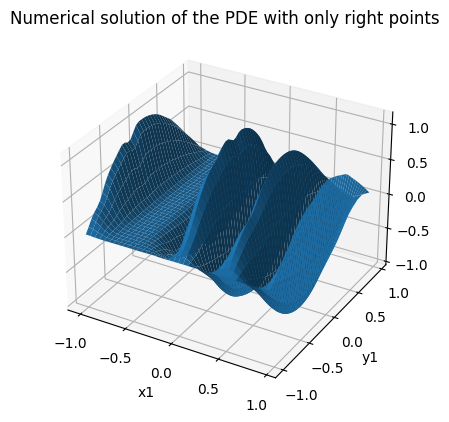

In [14]:
fig=plot_vectorized_function(u_right)
plt.title('Numerical solution of the PDE with only right points')
plt.show()

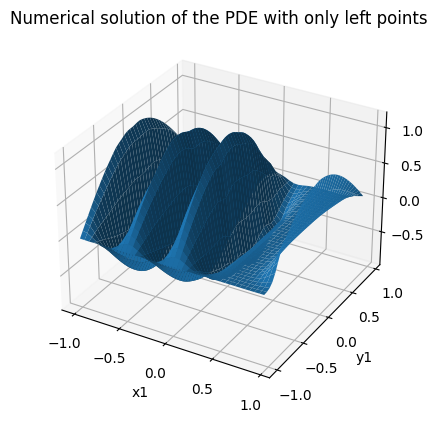

In [15]:
fig=plot_vectorized_function(u_left)
plt.title('Numerical solution of the PDE with only left points')
plt.show()

In [16]:
aggregate=Aggregate([u_left,u_right],sigma=sigma,nugget=1e-5)

M [[-6.71948090e-05  6.88851986e-03]
 [-1.08427987e-03  4.61546899e-03]
 [-3.05085910e-03  1.27604427e-03]
 ...
 [ 2.66201137e-02 -2.27121003e-02]
 [ 4.36667223e-02  2.49658226e-02]
 [ 6.25051727e-02  6.29123365e-02]]
COV mat [[[0.99999897 0.99698053]
  [0.99698053 0.99700498]]

 [[0.99995993 0.93945439]
  [0.93945439 0.93952604]]

 [[0.99971204 0.98058225]
  [0.98058225 0.98085042]]

 ...

 [[0.79089862 0.79088571]
  [0.79088571 1.00000566]]

 [[0.85403506 0.85399236]
  [0.85399236 0.99999658]]

 [[0.93154904 0.9315405 ]
  [0.9315405  0.99998933]]]
COV Y [[0.99998897 0.99699498]
 [0.99994993 0.93951604]
 [0.99970204 0.98084042]
 ...
 [0.79088862 0.99999566]
 [0.85402506 0.99998658]
 [0.93153904 0.99997933]]
alpha [[9.91965253e-01 8.04904242e-03]
 [9.98817219e-01 1.24831367e-03]
 [9.86178871e-01 1.40805622e-02]
 ...
 [6.54374199e-05 9.99938247e-01]
 [3.30641597e-04 9.99707634e-01]
 [1.23177324e-04 9.99875254e-01]]


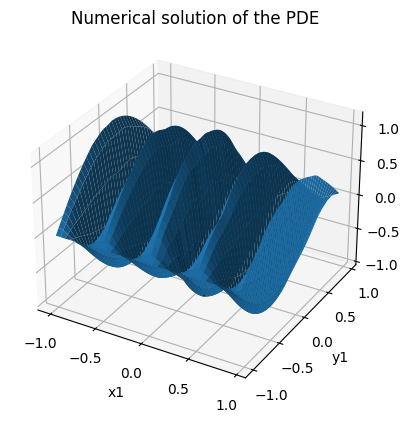

In [17]:
fig=plot_vectorized_function(aggregate,0.05)
plt.title('Numerical solution of the PDE')
plt.show()

In [18]:
def prepare_B(model1,model2):

    K12=PDESolver.get_covariance_matrix(model1.X_all,model2.X_all,model1.Nd,model2.Nd,sigma,model1.nugget)
    K=np.block([[model1.K_mat,K12],[K12.T,model2.K_mat]])
    
    Kinv_1=model1.L.T@model1.L
    Kinv_2=model2.L.T@model2.L
    K1K2=np.block([[Kinv_1,np.zeros((Kinv_1.shape[0],Kinv_2.shape[1]))],[np.zeros((Kinv_2.shape[0],Kinv_1.shape[1])),Kinv_2]])
    K_half=sqrtm(K).real
    A=K_half@K1K2
    print(A)
    def big_k(x):
        k1x=PDESolver.get_kernel_vector(model1.X_all,model1.Nd,model1.sigma,x)
        k2x=PDESolver.get_kernel_vector(model2.X_all,model2.Nd,model2.sigma,x)

        return np.block([[k1x,np.zeros_like(k1x)],[np.zeros_like(k2x),k2x]])
    return lambda x:A@big_k(x),K_half,K1K2


In [19]:
def big_k(x):
        k1x=PDESolver.get_kernel_vector(u_left.X_all,u_left.Nd,u_left.sigma,x)
        k2x=PDESolver.get_kernel_vector(u_right.X_all,u_right.Nd,u_right.sigma,x)

        return np.block([[k1x,np.zeros_like(k1x)],[np.zeros_like(k2x),k2x]])

In [20]:
B,K_half,K1K2=prepare_B(u_left,u_right)

[[ 2.48273839e+02  9.11852879e-01 -1.38123920e+01 ... -1.08593269e-03
  -9.34964358e-08  1.04281901e-04]
 [ 4.62206477e-01  1.62775260e+02 -4.48899234e-02 ... -5.55867681e-04
  -2.21585834e-04 -1.37097301e-04]
 [-1.00830081e+01 -2.79773675e-01  2.57336121e+02 ... -8.26146602e-04
   9.75049513e-05  1.27264445e-03]
 ...
 [-6.62811241e-01 -5.62092917e-02 -3.59250491e-01 ...  3.81428815e-02
  -2.31298109e-05 -2.96703967e-03]
 [ 1.53356241e-02  2.37489980e-01  3.41906253e-02 ...  3.61337282e-06
   2.94478624e-02 -1.97286543e-04]
 [ 4.91145159e-03  3.51263757e-02  5.17174384e-02 ... -2.84878286e-03
  -7.90405930e-06  5.24992850e-01]]


In [21]:
K=K_half@K_half

In [22]:
K_for_alpha=K@K1K2

In [23]:
x_to_test=np.array([[-0.7,0.6]])

In [24]:
b=B(x_to_test)
eigenvectors = np.linalg.eig(b@np.linalg.pinv(b))[1].real

In [25]:
alpha_mat = np.linalg.pinv(b)@np.linalg.inv(K_half@K1K2@K_half)@b
print(alpha_mat)

[[ 1.00012347e+00 -1.23488687e-04]
 [-9.99982212e-01  1.00012346e+00]]


In [26]:
alpha_inv_mat = np.linalg.pinv(big_k(x_to_test))@K_for_alpha@big_k(x_to_test)
print(alpha_inv_mat)

[[ 1.         -0.00238694]
 [ 0.99271143  1.        ]]


In [27]:
alpha_inv_mat@alpha_mat

array([[ 1.00251037, -0.00251072],
       [-0.00714822,  1.00000087]])

In [28]:
np.linalg.solve(np.linalg.pinv(big_k(x_to_test))@K_for_alpha@big_k(x_to_test),np.ones(2))

array([1.00001736, 0.00727134])

In [29]:
aggregate.alpha(x_to_test)

COV mat [[[9.99900006e-01 1.23459133e-04]
  [1.23459133e-04 1.33476571e-04]]]
COV Y [[9.99890006e-01 1.23476571e-04]]


array([[9.99989982e-01, 1.39906930e-04]])

In [30]:
half_eigenvalues,half_eigenvectors=np.linalg.eigh(K_half)
half_eigenvectors[:,1]

array([ 4.33422900e-02, -4.52769765e-02,  7.70753752e-03, ...,
       -2.81220748e-07,  4.40440164e-06, -1.07290992e-07])

In [31]:
half_eigenvalues

array([3.16227460e-03, 3.16227484e-03, 3.16227527e-03, ...,
       8.35812622e+02, 8.49805634e+02, 8.70890889e+02])

In [32]:
print(np.linalg.norm(K_half@eigenvectors[:,0]))
print(np.dot(eigenvectors[:,0],K_half@eigenvectors[:,0]))
print(np.dot(eigenvectors[:,50],K_half@eigenvectors[:,0]))

183.72681060703658
119.08005845984997
-5.179063560465277


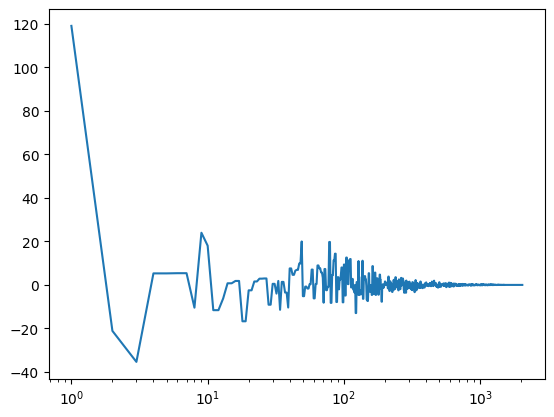

In [33]:
plt.plot(range(1,1+half_eigenvectors.shape[0]),eigenvectors.T@(K_half@eigenvectors[:,0]))
plt.xscale('log')

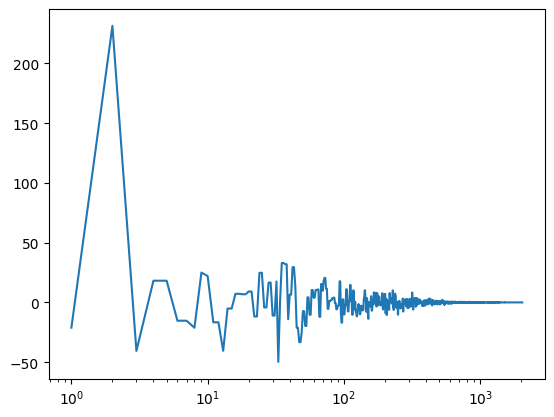

In [34]:
plt.plot(range(1,1+half_eigenvectors.shape[0]),eigenvectors.T@(K_half@eigenvectors[:,1]))
plt.xscale('log')

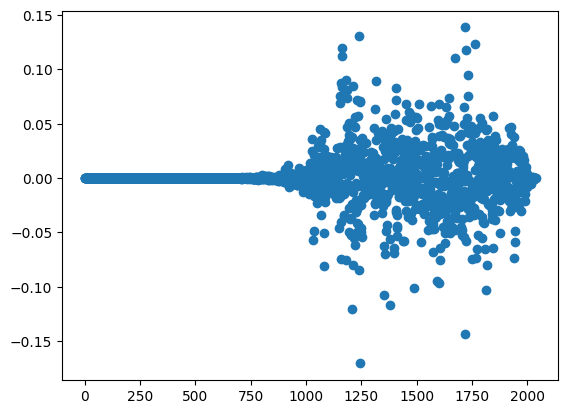

In [35]:
plt.scatter(range(half_eigenvectors.shape[0]),half_eigenvectors.T@eigenvectors[:,0])

In [36]:
np.dot(eigenvectors[5],K_half@eigenvectors[0])

-0.004661539480790147